# Opentender.eu datasets for Ireland

## Load and transform dataset
Datasets downloaded in json format from https://opentender.eu/all/download for EU institutions. Extract and store the archives in `data_json_opentender/data-ie-json`.

In [1]:
country_code = "ie"

In [4]:
import glob
import json
import pandas as pd
from fastlid import fastlid


cols = ['title_description', 'cpvs']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        cpvs = element.get("cpvs", [])
        result_cpvs = []
        for cpv in cpvs:
            result = cpv.get("code", "na")
            if result and result != "na":
                result = result[:2]
                if result in all_divisions:
                    result_cpvs.append(result)
        title = element.get('title', '')
        if title:
            title = f'{title}. '
        description = element.get('description', '')

        title_description = f'{title}{description}'
        fastlid_output = fastlid(title_description)
        lang = fastlid_output[0]
        confidence = fastlid_output[1]
        #if lang == "en" and confidence > 0.4:
        if result_cpvs and title_description:
            lst = [title_description, result_cpvs]
            data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-ie-json/data-ie-2019.json', 'data_json_opentender/data-ie-json/data-ie-2010.json', 'data_json_opentender/data-ie-json/data-ie-2011.json', 'data_json_opentender/data-ie-json/data-ie-2016.json', 'data_json_opentender/data-ie-json/data-ie-2009.json', 'data_json_opentender/data-ie-json/data-ie-2015.json', 'data_json_opentender/data-ie-json/data-ie-2012.json', 'data_json_opentender/data-ie-json/data-ie-2013.json', 'data_json_opentender/data-ie-json/data-ie-year-unavailable.json', 'data_json_opentender/data-ie-json/data-ie-2018.json', 'data_json_opentender/data-ie-json/data-ie-2022.json', 'data_json_opentender/data-ie-json/data-ie-2014.json', 'data_json_opentender/data-ie-json/data-ie-2021.json', 'data_json_opentender/data-ie-json/data-ie-2020.json', 'data_json_opentender/data-ie-json/data-ie-2017.json']


title_description  \
93561  J555 - Resurfacing of Existing Carpark with An...   
93562  CON/0016/2017 - Quantity Surveying Service in ...   
93563  Crescent 0517 - School cleaning services. Cres...   
93564  AC-2017-06 - Provision of Advisory Services: C...   
93565  1716 - Proposed Internal Alterations and Upgra...   

                                               cpvs  
93561                                  [45, 45, 45]  
93562                                      [71, 71]  
93563  [90, 90, 90, 90, 90, 90, 90, 90, 90, 79, 79]  
93564                                  [85, 73, 79]  
93565                                          [45]

In [5]:
df.describe()

title_description   cpvs
count                                               93566  93566
unique                                              93343  20216
top     Healthcare Fit Out. Healthcare Fit OutThe exis...   [45]
freq                                                    4   6112

In [6]:
df.to_csv(f"data_json_opentender/notices_{country_code}_only_no_filters.csv")

In [44]:
import re
from unidecode import unidecode
import spacy.cli


spacy.cli.download("en_core_web_sm")
NLP = spacy.load("en_core_web_sm")
STOP_WORDS = NLP.Defaults.stop_words
CHARACTERS_TO_REPLACE = ["\\n", "\\r", "\\t", "\\W", "•", "\t", "-", "(", ")", ":", ";", "?", "!", "&", "\n", "\r", ".", ",", "'", "’", "´",
                         "‘", "’", '"', "“", "”", "'", "/", "\\", "%", "—", "#", "$", "[", "]", "|", "{", "}", "~", "`", "+", "*"]

MONTHS = [" january ", " february ", " march ", " april ", " may ", " june ", " july ", " august ", " september ", " october ", " november ", " december ",
          " jan ", " feb ", " mar ", " apr ", " jun ", " jul ", " aug ", " sep ", " oct ", " nov ", " dec "]

          
def _remove_multiple_spaces(text: str) -> str:
    return re.sub('\s+', ' ', text)


def _remove_special_characters(text: str) -> str:
    for chars in CHARACTERS_TO_REPLACE:
        text = text.replace(chars, " ")
    return text


def _remove_stop_words(text: str) -> str:
    token_list = text.split()
    removed_list = [x for x in token_list if x not in STOP_WORDS]
    return ' '.join(removed_list)


def _replace_digits(text):
    return re.sub(r'[\d-]+', 'NUMBER', text)


def _delete_one_letter_word(text):
    text_as_list = text.split()
    text_as_list = [element for element in text_as_list if len(element) > 1]
    return ' '.join(text_as_list)


def _remove_consecutive_duplicates(text):
    text_as_list = text.split()
    last_seen = None
    result = []
    for x in text_as_list:
        if x != last_seen:
            result.append(x)
        last_seen = x
    return ' '.join(result)

          
def _replace_months(text: str) -> str:
    text = " " + text + " "
    for month in MONTHS:
        text = text.replace(month, " MONTH ")
    return text


def _replace_with_lemma(text: str) -> str:
    doc = NLP(text)
    lemmatized_list = []
    for token in doc:
        lemmatized_list.append(token.lemma_)
    return " ".join(lemmatized_list)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    # finally, compute metrics
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [9]:
from ast import literal_eval
import glob
import json
import pandas as pd
from fastlid import fastlid


df = pd.read_csv(f'data_json_opentender/notices_{country_code}_only_no_filters.csv', converters={"cpvs": literal_eval}, index_col=0)

In [10]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description     71     44     50  \
0  Marina Park Phase 1. The Marina Park Phase 1 p...  False  False  False   

      80     73    45     85     79     90  ...     18     03     43     24  \
0  False  False  True  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  

[1 rows x 46 columns]

In [11]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                 92317
unique                                                92317
top        marina park phase NUMBER marina park phase NU...
freq                                                      1
Name: title_description, dtype: object

In [12]:
df.to_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv")

In [2]:
import pandas as pd
df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country_code}_only_no_filters.csv", index_col=0)
df.head()

title_description     71     44     50  \
0   marina park phase NUMBER marina park phase NU...  False  False  False   
1   provision update maintenance development webs...  False  False  False   
2   national concert hall redevelopment programme...   True  False  False   
3   rituximab biosimilar seek bid suitably licens...  False  False  False   
4   ucc rft plasma chemical vapour deposition sys...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False   True  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False  False  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False  False  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [3]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='c', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

Text(0.5, 0, 'CPV division')

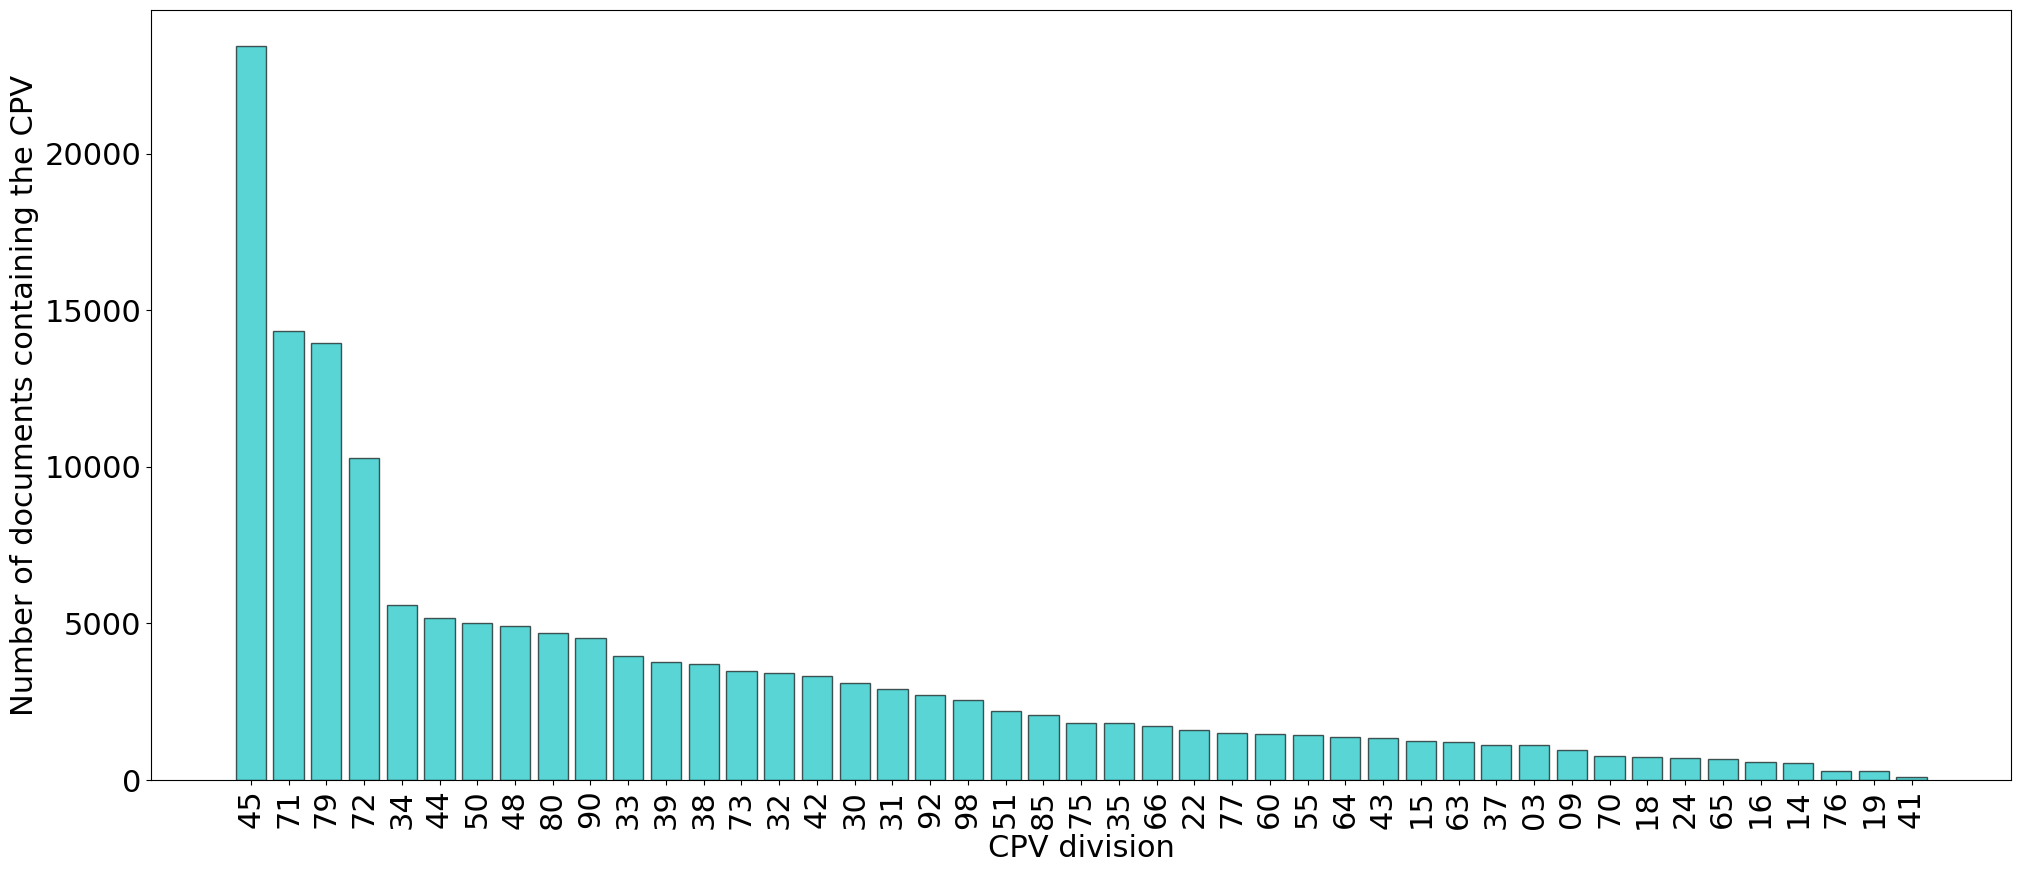

In [4]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


## Train model

In [7]:
from sklearn import metrics

X = df['title_description']
Y = df.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)


clf fit done


In [8]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.83      0.79      0.81      2866
          44       0.66      0.45      0.53      1054
          50       0.72      0.59      0.65       981
          80       0.83      0.79      0.81       943
          73       0.69      0.57      0.62       690
          45       0.90      0.89      0.90      4716
          85       0.76      0.65      0.70       396
          79       0.78      0.77      0.78      2671
          90       0.81      0.71      0.76       934
          30       0.76      0.61      0.68       584
          35       0.68      0.55      0.61       343
          33       0.80      0.74      0.77       819
          55       0.83      0.82      0.83       278
          72       0.77      0.72      0.75      2037
          48       0.66      0.62      0.64       963
          38       0.78      0.75      0.76       717
          09       0.79      0.63      0.70       188
          75       0.67    

## Predictions on data from other countries

In [9]:
list_of_countries = ["ie", "no", "uk", "eu"]
list_of_countries.remove(country_code)

for country in list_of_countries:
    df = pd.read_csv(f"data_json_opentender/with_lemma_preprocessed_notices_{country}_only_no_filters.csv", index_col=0)
    print("====================================================\n")
    print(f"Country: {country}")
    X = df['title_description']
    Y = df.drop(['title_description'], axis=1)
    y_pred = SVC_pipeline.predict(X)
    print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
    print(multi_label_metrics(Y, y_pred))
    print("====================================================\n")



Country: no


/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.60      0.15      0.24     20912
          44       0.42      0.04      0.08      9433
          50       0.16      0.09      0.11      7632
          80       0.50      0.05      0.09      6441
          73       0.49      0.05      0.09      6186
          45       0.60      0.13      0.21     85428
          85       0.47      0.04      0.07      4884
          79       0.47      0.21      0.29     13142
          90       0.73      0.19      0.31     11340
          30       0.14      0.22      0.17      7246
          35       0.23      0.06      0.09      2382
          33       0.78      0.16      0.27     12894
          55       0.73      0.12      0.20      1879
          72       0.54      0.21      0.31     13998
          48       0.31      0.15      0.20      8659
          38       0.41      0.24      0.30      5376
          09       0.79      0.13      0.22      1992
          75       0.05    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          71       0.51      0.45      0.48     32218
          44       0.41      0.17      0.24     14264
          50       0.56      0.43      0.49     20363
          80       0.65      0.54      0.59     18155
          73       0.49      0.28      0.36     19875
          45       0.72      0.73      0.73     63683
          85       0.84      0.33      0.47     33984
          79       0.50      0.59      0.54     48598
          90       0.71      0.58      0.64     17154
          30       0.53      0.32      0.40      7103
          35       0.41      0.27      0.33      5395
          33       0.64      0.38      0.47     14999
          55       0.77      0.66      0.71      5015
          72       0.42      0.52      0.46     28095
          48       0.55      0.49      0.52     20149
          38       0.62      0.47      0.53     11902
          09       0.70      0.41      0.52      4144
          75       0.29    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

              precision    recall  f1-score   support

          71       0.14      0.09      0.11       465
          44       0.17      0.01      0.03      1604
          50       0.43      0.05      0.09       848
          80       0.63      0.46      0.53       230
          73       0.36      0.22      0.28       428
          45       0.04      0.11      0.06       436
          85       0.32      0.06      0.10       249
          79       0.21      0.44      0.28      1352
          90       0.45      0.17      0.25       331
          30       0.36      0.23      0.28      2189
          35       0.13      0.04      0.06       236
          33       0.85      0.10      0.18      7918
          55       0.62      0.31      0.41        95
          72       0.30      0.45      0.36       493
          48       0.04      0.21      0.07       171
          38       0.21      0.17      0.19       279
          09       0.28      0.05      0.08       168
          75       0.27    

## Predictions on dataset since january 2023
Dataset available on S3: s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20220221-dataset_since_january_2023.csv ; 

In [19]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [20]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline.predict(X)
print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

              precision    recall  f1-score   support

          71       0.60      0.67      0.63         9
          44       0.00      0.00      0.00         1
          50       0.25      0.33      0.29         3
          80       1.00      0.83      0.91         6
          73       0.33      0.29      0.31         7
          45       0.76      0.93      0.84        14
          85       1.00      0.67      0.80         3
          79       0.73      0.92      0.81        26
          90       0.75      0.86      0.80         7
          30       0.67      1.00      0.80         2
          35       0.67      0.67      0.67         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.29      0.71      0.42         7
          48       0.67      1.00      0.80         2
          38       0.50      1.00      0.67         1
          09       0.00      0.00      0.00         0
          75       0.00    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

# With Filters above/below thresholds

In [47]:
import glob
import json
import pandas as pd
from fastlid import fastlid

cols = ['title_description', 'cpvs', 'size']
data = []
list_jsons = glob.glob(f"data_json_opentender/data-{country_code}-json/*")
print(list_jsons)
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

for file_name in list_jsons:
    with open(file_name) as f:
        doc = json.load(f)

    for element in doc:
        size = element.get("size", None)
        if size:
            cpvs = element.get("cpvs", [])
            result_cpvs = []
            for cpv in cpvs:
                result = cpv.get("code", "na")
                if result and result != "na":
                    result = result[:2]
                    if result in all_divisions:
                        result_cpvs.append(result)
            title = element.get('title', '')
            if title:
                title = f'{title}. '
            description = element.get('description', '')

            title_description = f'{title}{description}'
            if result_cpvs and title_description:
                lst = [title_description, result_cpvs, size]
                data.append(lst)

df = pd.DataFrame(data=data, columns=cols)
df.tail()

['data_json_opentender/data-ie-json/data-ie-2019.json', 'data_json_opentender/data-ie-json/data-ie-2010.json', 'data_json_opentender/data-ie-json/data-ie-2011.json', 'data_json_opentender/data-ie-json/data-ie-2016.json', 'data_json_opentender/data-ie-json/data-ie-2009.json', 'data_json_opentender/data-ie-json/data-ie-2015.json', 'data_json_opentender/data-ie-json/data-ie-2012.json', 'data_json_opentender/data-ie-json/data-ie-2013.json', 'data_json_opentender/data-ie-json/data-ie-year-unavailable.json', 'data_json_opentender/data-ie-json/data-ie-2018.json', 'data_json_opentender/data-ie-json/data-ie-2022.json', 'data_json_opentender/data-ie-json/data-ie-2014.json', 'data_json_opentender/data-ie-json/data-ie-2021.json', 'data_json_opentender/data-ie-json/data-ie-2020.json', 'data_json_opentender/data-ie-json/data-ie-2017.json']


title_description  cpvs  \
9165  The collection, transport and disposal of Haza...  [90]   
9166  ITT for Digital Marketing in China. Invitation...  [79]   
9167  Lubricants, AntiFreeze & Greases Contract 2017...  [09]   
9168  Provision of a collection/transfer of furnitur...  [60]   
9169  Provision of cost management support services....  [71]   

                     size  
9165  ABOVE_THE_THRESHOLD  
9166  ABOVE_THE_THRESHOLD  
9167  ABOVE_THE_THRESHOLD  
9168  ABOVE_THE_THRESHOLD  
9169  ABOVE_THE_THRESHOLD

In [48]:
df = df.drop_duplicates(subset=['title_description'], keep='last')

In [49]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]

def has_given_label(label, list_of_labels):
    if list_of_labels is None:
        return False
    list_of_labels = [i.lower() for i in list_of_labels]
    if label in list_of_labels:
        return True
    else:
        return False

for element in all_cpvs:
    df[element] = df["cpvs"].apply(lambda x: has_given_label(element, x))

df = df.drop(['cpvs'], axis = 1)
df.head(1)

title_description                 size  \
0  Marina Park Phase 1. The Marina Park Phase 1 p...  BELOW_THE_THRESHOLD   

      71     44     50     80     73    45     85     79  ...     18     03  \
0  False  False  False  False  False  True  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
0  False  False  False  False  False  False  False  False  

[1 rows x 47 columns]

In [50]:
df['title_description'] = df['title_description'].apply(lambda x: unidecode(str(x).lower()))
df['title_description'] = df['title_description'].apply(lambda x: _replace_with_lemma(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_special_characters(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_stop_words(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_multiple_spaces(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_digits(x))
df['title_description'] = df['title_description'].apply(lambda x: _delete_one_letter_word(x))
df['title_description'] = df['title_description'].apply(lambda x: _remove_consecutive_duplicates(x))
df['title_description'] = df['title_description'].apply(lambda x: _replace_months(x))
df = df.drop_duplicates(subset=['title_description'], keep='last')
df["title_description"].describe()

count                                                  9070
unique                                                 9070
top        marina park phase NUMBER marina park phase NU...
freq                                                      1
Name: title_description, dtype: object

In [51]:
df.to_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv")

In [52]:
df = pd.read_csv(f"opentenders_{country_code}_preprocessed_title_description_with_size.csv", index_col=0)

In [53]:
df["size"].describe()

count                    9070
unique                      2
top       ABOVE_THE_THRESHOLD
freq                     7383
Name: size, dtype: object

In [54]:
df["size"].unique()

array(['BELOW_THE_THRESHOLD', 'ABOVE_THE_THRESHOLD'], dtype=object)

In [55]:
df_below_threshold = df[df["size"] == "BELOW_THE_THRESHOLD"]
df_above_threshold = df[df["size"] == "ABOVE_THE_THRESHOLD"]
df_below_threshold.head()

title_description                 size  \
0    marina park phase NUMBER marina park phase NU...  BELOW_THE_THRESHOLD   
2    rituximab biosimilar seek bid suitably licens...  BELOW_THE_THRESHOLD   
6    supply metalwork engineering classroom materi...  BELOW_THE_THRESHOLD   
8    tralee town centre share space tralee town ce...  BELOW_THE_THRESHOLD   
14   internal audit service land development agenc...  BELOW_THE_THRESHOLD   

       71     44     50     80     73     45     85     79  ...     18     03  \
0   False  False  False  False  False   True  False  False  ...  False  False   
2   False  False  False  False  False  False  False  False  ...  False  False   
6   False  False  False  False  False   True  False  False  ...  False  False   
8    True  False  False  False  False  False  False  False  ...  False  False   
14  False  False  False  False  False  False  False   True  ...  False  False   

       43     24     19     41     37     14     16     76  
0   False  False  False  False  False  False  False  False  
2   False  False  False  False  False  False  False  False  
6   False  False  False  False  False  False  False  False  
8   False  False  False  False  False  False  False  False  
14  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

In [56]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_below_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


Text(0.5, 0, 'CPV division')

Text(0.5, 0, 'CPV division')

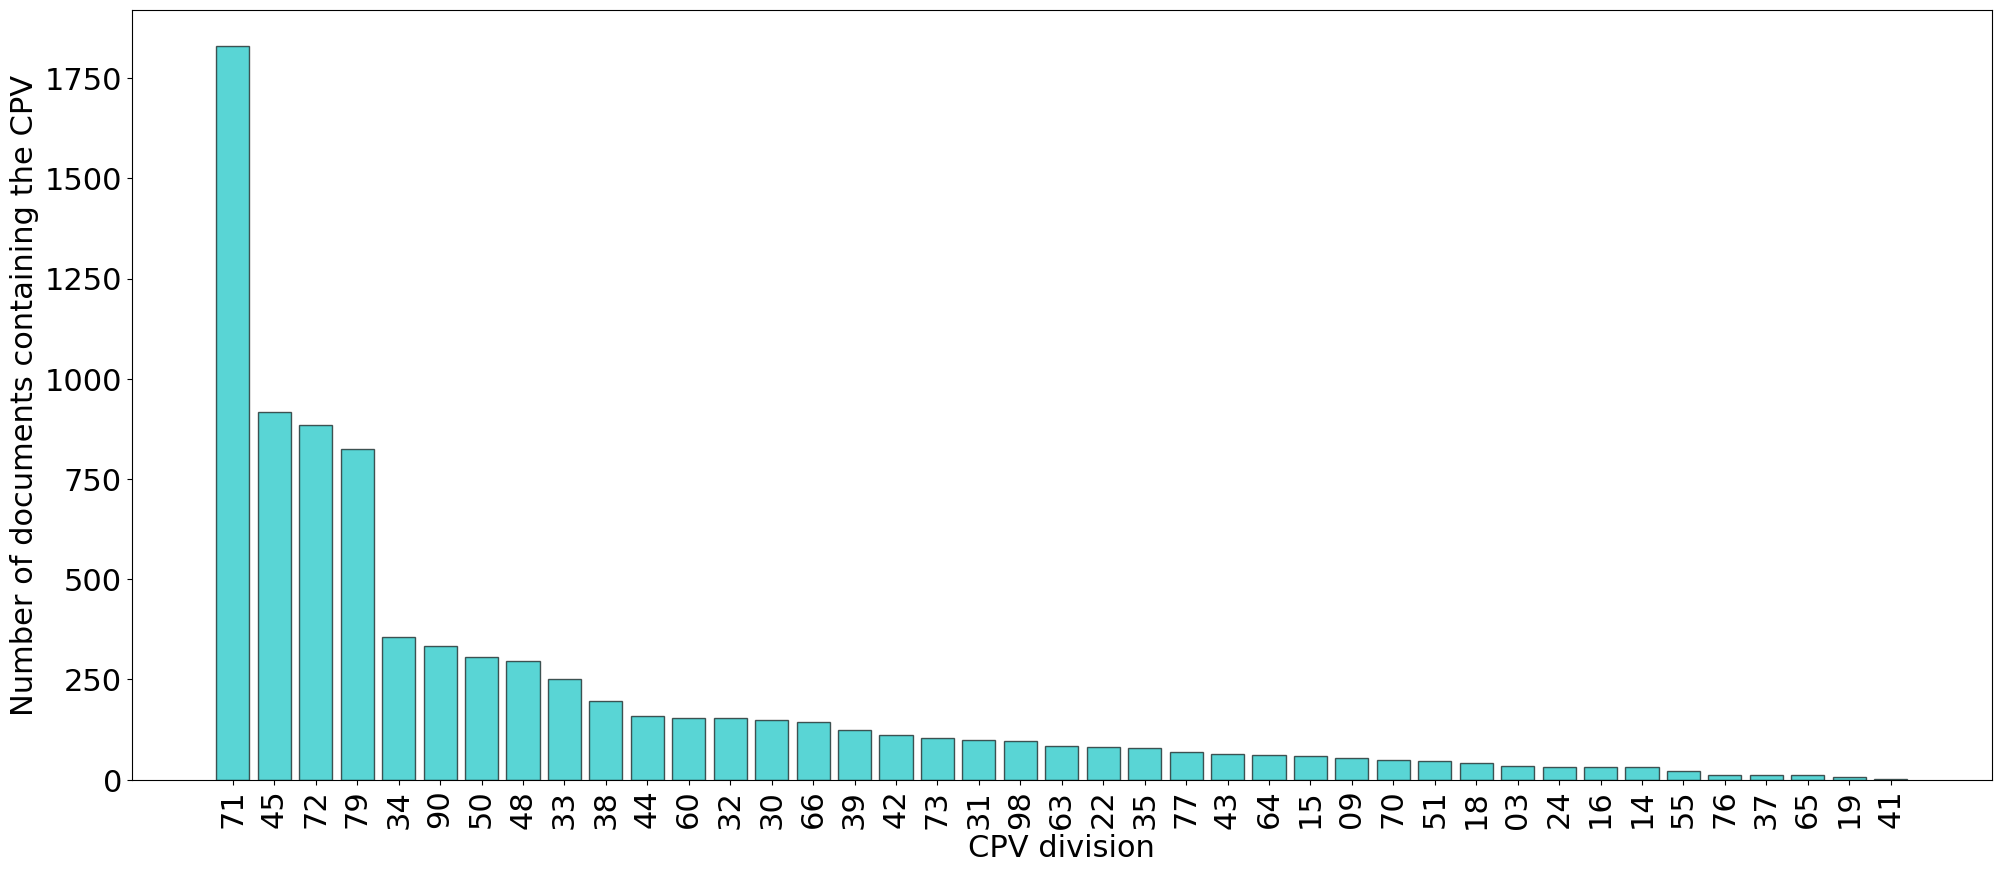

In [57]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
count_of_cpvs = count_elements_in_dataframe_from_columns(df_above_threshold, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")


In [58]:
df_below_threshold.describe()

title_description  \
count                                                1687   
unique                                               1687   
top      marina park phase NUMBER marina park phase NU...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                  1687   1687   1687   1687   1687   1687   1687   1687   
unique                    1      2      2      2      1      2      2      1   
top     BELOW_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                   1687   1447   1647   1609   1687   1639   1631   1687   

           79  ...     18     03     43     24     19     41     37     14  \
count    1687  ...   1687   1687   1687   1687   1687   1687   1687   1687   
unique      2  ...      2      2      2      2      2      2      2      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq     1439  ...   1679   1676   1675   1677   1685   1684   1676   1682   

           16     76  
count    1687   1687  
unique      2      1  
top     False  False  
freq     1673   1687  

[4 rows x 47 columns]

In [59]:
df_above_threshold.describe()

title_description  \
count                                                7383   
unique                                               7383   
top      provision update maintenance development webs...   
freq                                                    1   

                       size     71     44     50     80     73     45     85  \
count                  7383   7383   7383   7383   7383   7383   7383   7383   
unique                    1      2      2      2      1      2      2      1   
top     ABOVE_THE_THRESHOLD  False  False  False  False  False  False  False   
freq                   7383   5554   7224   7078   7383   7278   6465   7383   

           79  ...     18     03     43     24     19     41     37     14  \
count    7383  ...   7383   7383   7383   7383   7383   7383   7383   7383   
unique      2  ...      2      2      2      2      2      2      2      2   
top     False  ...  False  False  False  False  False  False  False  False   
freq     6557  ...   7341   7349   7320   7351   7376   7382   7372   7352   

           16     76  
count    7383   7383  
unique      2      2  
top     False  False  
freq     7352   7372  

[4 rows x 47 columns]

In [60]:
df_above_threshold.head()

title_description                 size  \
1   provision update maintenance development webs...  ABOVE_THE_THRESHOLD   
3   ucc rft plasma chemical vapour deposition sys...  ABOVE_THE_THRESHOLD   
4   ict network support service tii requirement p...  ABOVE_THE_THRESHOLD   
5   unify communication university microsoft skyp...  ABOVE_THE_THRESHOLD   
7   multi supplier framework agreement audio visu...  ABOVE_THE_THRESHOLD   

      71     44     50     80     73     45     85     79  ...     18     03  \
1  False  False  False  False  False  False  False  False  ...  False  False   
3  False  False  False  False  False  False  False  False  ...  False  False   
4  False  False  False  False  False  False  False  False  ...  False  False   
5  False  False  False  False  False  False  False  False  ...  False  False   
7  False  False  False  False  False  False  False  False  ...  False  False   

      43     24     19     41     37     14     16     76  
1  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  
5  False  False  False  False  False  False  False  False  
7  False  False  False  False  False  False  False  False  

[5 rows x 47 columns]

In [61]:
all_cpvs = ['71', '44', '50', '80', '73', '45', '85', '79', '90', '30', '35', '33', '55', '72',
 '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51',
 '77', '22', '32', '63', '15', '65', '70', '18', '03', '43', '24', '19', '41', '37',
 '14', '16', '76',]
df_above_threshold = df_above_threshold.drop(["size"], axis = 1)
df_below_threshold = df_below_threshold.drop(["size"], axis = 1)

In [62]:
from sklearn import metrics

X = df_above_threshold['title_description']
Y = df_above_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_above = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_above.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_above.predict(X_test)
print("Above threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


clf fit done
Above threshold: 

              precision    recall  f1-score   support

          71       0.90      0.83      0.87       384
          44       0.83      0.32      0.47        31
          50       0.74      0.57      0.65        61
          80       0.00      0.00      0.00         0
          73       0.88      0.30      0.45        23
          45       0.90      0.81      0.85       196
          85       0.00      0.00      0.00         0
          79       0.85      0.61      0.71       175
          90       0.83      0.73      0.78        67
          30       0.56      0.45      0.50        20
          35       0.82      0.53      0.64        17
          33       0.81      0.68      0.74        44
          55       1.00      0.20      0.33         5
          72       0.76      0.66      0.70       164
          48       0.53      0.38      0.44        48
          38       0.68      0.37      0.48        35
          09       0.86      0.67      0.75      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [63]:
from sklearn import metrics

X = df_below_threshold['title_description']
Y = df_below_threshold.drop(['title_description'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


SVC_pipeline_below = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline_below.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline_below.predict(X_test)
print("Below threshold: \n")
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(


clf fit done
Below threshold: 

              precision    recall  f1-score   support

          71       0.89      0.60      0.71        52
          44       0.67      0.20      0.31        10
          50       0.80      0.40      0.53        10
          80       0.00      0.00      0.00         0
          73       0.00      0.00      0.00        15
          45       1.00      0.08      0.14        13
          85       0.00      0.00      0.00         0
          79       0.83      0.53      0.64        55
          90       0.71      0.42      0.53        12
          30       0.00      0.00      0.00         9
          35       0.00      0.00      0.00         1
          33       0.33      0.06      0.11        16
          55       0.00      0.00      0.00         1
          72       0.74      0.54      0.62        46
          48       0.46      0.23      0.31        26
          38       0.80      0.41      0.55        29
          09       0.00      0.00      0.00      

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 44 is present in all training examples.
  warnings.warn(
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: Undef

## Against eu institution notices from january 2023

In [64]:
df = pd.read_csv("20230221-preprocessed_dataset_since_january_2023.csv", index_col=0)
df.head(5)

title_texte     71     44     50  \
0   service consult software development internet...  False  False  False   
1   supply installation access control intrusion ...  False  False  False   
2   performance external examination target servi...  False  False  False   
3                  construction machinery equipment   False  False  False   
4   provision travel agency service frontex subje...  False  False  False   

      80     73     45     85     79     90  ...     18     03     43     24  \
0  False  False  False  False  False  False  ...  False  False  False  False   
1  False  False  False  False  False  False  ...  False  False  False  False   
2  False  False  False  False   True  False  ...  False  False  False  False   
3  False  False  False  False  False  False  ...  False  False   True  False   
4  False  False  False  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
0  False  False  False  False  False  False  
1  False  False  False  False  False  False  
2  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  

[5 rows x 46 columns]

In [65]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_above.predict(X)
print("Above threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Above threshold: 

              precision    recall  f1-score   support

          71       0.50      0.56      0.53         9
          44       0.00      0.00      0.00         1
          50       1.00      0.33      0.50         3
          80       0.00      0.00      0.00         6
          73       0.00      0.00      0.00         7
          45       0.79      0.79      0.79        14
          85       0.00      0.00      0.00         3
          79       0.57      0.31      0.40        26
          90       0.80      0.57      0.67         7
          30       0.00      0.00      0.00         2
          35       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          55       1.00      1.00      1.00         2
          72       0.67      0.86      0.75         7
          48       0.33      0.50      0.40         2
          38       1.00      1.00      1.00         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [66]:
X = df['title_texte']
Y = df.drop(['title_texte'], axis=1)
y_pred = SVC_pipeline_below.predict(X)
print("Below threshold: \n")

print(metrics.classification_report(Y, y_pred, target_names=all_cpvs))
print(multi_label_metrics(Y, y_pred))

Below threshold: 

              precision    recall  f1-score   support

          71       0.43      0.33      0.38         9
          44       0.00      0.00      0.00         1
          50       1.00      0.33      0.50         3
          80       0.00      0.00      0.00         6
          73       0.00      0.00      0.00         7
          45       1.00      0.07      0.13        14
          85       0.00      0.00      0.00         3
          79       0.83      0.38      0.53        26
          90       0.80      0.57      0.67         7
          30       0.00      0.00      0.00         2
          35       0.00      0.00      0.00         3
          33       0.00      0.00      0.00         0
          55       0.00      0.00      0.00         2
          72       0.62      0.71      0.67         7
          48       0.50      0.50      0.50         2
          38       1.00      1.00      1.00         1
          09       0.00      0.00      0.00         0
        

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(a